In [ ]:
import pm4py

log = pm4py.read_xes("after_super_puper_mega_filter.xes")

In [ ]:
import tqdm
import numpy
import pandas

def filter(event_log):
    event_log = event_log.copy()
    event_log_list = []
    for row in tqdm.tqdm(event_log.iterrows(), total = len(event_log)):
        event_log_list.append(row[1].to_dict())


    edges_in = {}
    edges_out = {}
    for i in tqdm.trange(len(event_log_list) - 1):
        if event_log_list[i]["case:concept:name"] != event_log_list[i + 1]["case:concept:name"]:
            continue

        cur_text = event_log_list[i]["concept:name"]
        next_text = event_log_list[i + 1]["concept:name"]

        if cur_text not in edges_out:
            edges_out[cur_text] = set()
        edges_out[cur_text].add(next_text)

        if next_text not in edges_in:
            edges_in[next_text] = set()
        edges_in[next_text].add(cur_text)
        
        if cur_text not in edges_in:
            edges_in[cur_text] = set()
        if next_text not in edges_out:
            edges_out[next_text] = set()


    edges_in_count = {}
    for key, value in edges_in.items():
        edges_in_count[key] = len(value)
    print(numpy.unique(list(edges_in_count.values()), return_counts = True))
    
    edges_out_count = {}
    for key, value in edges_out.items():
        edges_out_count[key] = len(value)
    print(numpy.unique(list(edges_out_count.values()), return_counts = True))
        
    i = 0
    pbar = tqdm.trange(0, len(event_log_list))
    pbar_iter = iter(pbar)
    while i < len(event_log_list) - 1:
        cur_event = event_log_list[i]
        next_event = event_log_list[i + 1]
        if cur_event["case:concept:name"] != next_event["case:concept:name"]:
            i += 1
            next(pbar_iter)
            continue

        exactly_one_out = (len(edges_out[cur_event['concept:name']]) == 1)
        exactly_one_in = (len(edges_in[next_event['concept:name']]) == 1)
        
        if not exactly_one_out or not exactly_one_in:
            i += 1
            next(pbar_iter)
            continue

        new_name = cur_event['concept:name'] + "\n" + next_event['concept:name']

        if new_name not in edges_in:
            edges_in[new_name] = set()
        edges_in[new_name] = edges_in[new_name].union(edges_in[cur_event['concept:name']])
        
        if new_name not in edges_out:
            edges_out[new_name] = set()
        edges_out[new_name] = edges_out[new_name].union(edges_out[next_event['concept:name']])

        event_log_list[i]['concept:name'] = new_name
        del event_log_list[i + 1]
        pbar.total = len(event_log_list)

    return pandas.DataFrame(event_log_list)

log_filt = filter(log)
log_filt

In [ ]:
log

In [ ]:
log["concept:name"].value_counts()

In [ ]:
import pandas

a = log.groupby("concept:name").agg({
    "case:concept:name": [ pandas.Series.nunique, lambda *args, **kwargs: pandas.Series.value_counts(*args, **kwargs, sort = False), "count" ],
}).reset_index()
a

In [ ]:
import numpy
a["min_value_counts"] = a["case:concept:name"]["<lambda_0>"].apply(numpy.min)
a["max_value_counts"] = a["case:concept:name"]["<lambda_0>"].apply(numpy.max)
a["count_value_counts"] = a["case:concept:name"]["count"]
a

In [ ]:
b = a[a['case:concept:name']['nunique'] == 12]
b

In [ ]:
c = b[
    # (b["min_value_counts"] > 0) &
    (b["max_value_counts"] > 10) &
    # (b["count_value_counts"] < 10000) &
    # ((b["max_value_counts"] - b["min_value_counts"]) < 6) &
    # (b["max_value_counts"] != b["min_value_counts"]) &
    
    (~b["concept:name"].str.contains("DiagnosticBag")) &
    ((~b["concept:name"].str.contains("Error")) | (b["concept:name"].str.contains("ErrorFacts.GetMessage"))) &
    # (~b["concept:name"].str.contains("Diagnostic")) &
    # (~b["concept:name"].str.contains("MessageProvider")) &

    (~b["concept:name"].str.contains("BindingDiagnosticBag")) &
    # (~b["concept:name"].str.contains("Common")) &
    (~b["concept:name"].str.contains("GreenNode.")) &
    (~b["concept:name"].str.contains("_Green")) &
    (~b["concept:name"].str.contains("CustomAttributesBag")) &
    # (~b["concept:name"].str.contains("Symbols.")) &
    # (~b["concept:name"].str.contains("Symbol.")) &
    # (~b["concept:name"].str.contains("Internal.")) &
    (~b["concept:name"].str.contains("SyntaxNode.")) &
    (~b["concept:name"].str.contains("SyntaxList")) &
    (~b["concept:name"].str.contains("SyntaxToken.")) &
    # (~b["concept:name"].str.contains("InternalSyntax.")) &
    # (~b["concept:name"].str.contains("PooledObjects.")) &
    (~b["concept:name"].str.contains("Text.")) &
    (~b["concept:name"].str.contains("PooledObjects.")) &
    (~b["concept:name"].str.contains("CachingIdentityFactory")) &
    (~b["concept:name"].str.contains("ExtendedSpecialType.")) &
    (~b["concept:name"].str.contains("ReadOnlyMemoryOfCharComparer.")) &
    (~b["concept:name"].str.contains("CachingBase")) &
    ((b["concept:name"].str.contains(":CSharp")) | (b["concept:name"].str.contains("CommonMessageProvider.GetIdForErrorCode")))
    # (~b["concept:name"].str.contains("HashSetExtensions."))
]
with pandas.option_context('display.max_colwidth', 200):
    print(len(c))
    display(c.sort_values(by = 'count_value_counts').tail(35))

In [ ]:
c = b[
    # (b["min_value_counts"] == 1) &
    (b["max_value_counts"] <= 2) &
    # (b["count_value_counts"] == 12) &
    # ((b["max_value_counts"] - b["min_value_counts"]) < 6) &
    # (b["max_value_counts"] != b["min_value_counts"]) &

    ~(b["concept:name"].str.contains("Error")) &
    ~(b["concept:name"].str.contains("Diagnostic"))
    
    & ~(b["concept:name"].str.contains("GreenNode"))
    & ~(b["concept:name"].str.contains("InternalSyntax"))
    & ~(b["concept:name"].str.contains("CSharpExtensions"))
    & ~(b["concept:name"].str.contains("CSharpSyntaxNode"))
    & ~(b["concept:name"].str.contains("SyntaxNodeExtensions"))
    & ~(b["concept:name"].str.contains("CSharpSyntaxTree"))
    & ~(b["concept:name"].str.contains("CSharp.Binder"))
    # & ~(b["concept:name"].str.contains("MergedTypeDeclaration"))
    # & ~(b["concept:name"].str.contains("MostCommonNullableValueBuilder"))
    
    & ~(b["concept:name"].str.contains(":CommandLine"))
    & ~(b["concept:name"].str.contains(":Emit"))
    & ~(b["concept:name"].str.contains(":Text"))
]
with pandas.option_context('display.max_colwidth', 200):
    print(len(c))
    # display(c.sort_values(by = 'count_value_counts', ascending = False).head(35))

In [ ]:
res = {}
for item in c["concept:name"].to_numpy():
    if "End:" in item:
        continue
    val = '.'.join(item.split('.')[:1])
    if val not in res:
        res[val] = set()
    res[val].add(item)

res2 = []
for key, value in res.items():
    res2.append({ "key": key, "value": len(value) })

df = pandas.DataFrame(res2)
print(df["value"].sum())
df.sort_values(by = "value", ascending = False).head(35)

In [ ]:
l = log[log["concept:name"].isin(c["concept:name"].to_numpy())]
l.shape

In [ ]:
dfg, start, end = pm4py.discover_dfg(log_filt.copy())

In [ ]:
pm4py.view_dfg(dfg, start, end)

In [ ]:
res = set()
for (_from, _to), value in dfg.items():
    if "InternalSyntax" not in _to:
        continue
    if "InternalSyntax" in _from:
        continue
    if "GreenNode" in _from:
        continue
    res.add(_from)
list(res)

In [ ]:
pm4py.write_xes(l, "analyze/sth.xes")

In [38]:
import tqdm
import numpy
import pandas

def filter(event_log):
    event_log = event_log.copy()
    event_log_list = []
    for row in tqdm.tqdm(event_log.iterrows(), total = len(event_log)):
        event_log_list.append(row[1].to_dict())


    edges_in = {}
    edges_out = {}
    for i in tqdm.trange(len(event_log_list) - 1):
        if event_log_list[i]["case:concept:name"] != event_log_list[i + 1]["case:concept:name"]:
            continue

        cur_text = event_log_list[i]["concept:name"]
        next_text = event_log_list[i + 1]["concept:name"]

        if cur_text not in edges_out:
            edges_out[cur_text] = set()
        edges_out[cur_text].add(next_text)

        if next_text not in edges_in:
            edges_in[next_text] = set()
        edges_in[next_text].add(cur_text)
        
        if cur_text not in edges_in:
            edges_in[cur_text] = set()
        if next_text not in edges_out:
            edges_out[next_text] = set()


    edges_in_count = {}
    for key, value in edges_in.items():
        edges_in_count[key] = len(value)
    print(numpy.unique(list(edges_in_count.values()), return_counts = True))
    
    edges_out_count = {}
    for key, value in edges_out.items():
        edges_out_count[key] = len(value)
    print(numpy.unique(list(edges_out_count.values()), return_counts = True))
        
    i = 0
    pbar = tqdm.trange(0, len(event_log_list))
    pbar_iter = iter(pbar)
    while i < len(event_log_list) - 1:
        cur_event = event_log_list[i]
        next_event = event_log_list[i + 1]
        if cur_event["case:concept:name"] != next_event["case:concept:name"]:
            i += 1
            next(pbar_iter)
            continue

        exactly_one_out = (len(edges_out[cur_event['concept:name']]) == 1)
        exactly_one_in = (len(edges_in[next_event['concept:name']]) == 1)
        
        if not exactly_one_out or not exactly_one_in:
            i += 1
            next(pbar_iter)
            continue

        new_name = cur_event['concept:name'] + "\n" + next_event['concept:name']

        if new_name not in edges_in:
            edges_in[new_name] = set()
        edges_in[new_name] = edges_in[new_name].union(edges_in[cur_event['concept:name']])
        
        if new_name not in edges_out:
            edges_out[new_name] = set()
        edges_out[new_name] = edges_out[new_name].union(edges_out[next_event['concept:name']])

        event_log_list[i]['concept:name'] = new_name
        del event_log_list[i + 1]
        pbar.total = len(event_log_list)

    return pandas.DataFrame(event_log_list)


In [ ]:

log_filt = filter(l)
log_filt

In [ ]:
import tqdm

traces = {}
for _, row in tqdm.tqdm(log.iterrows(), total = len(log)):
    traceid = row['case:concept:name']
    text = row['concept:name']
    if traceid not in traces:
        traces[traceid] = [ ]
    traces[traceid].append(text)

In [ ]:
i = 0
while True:
    texts = []
    for traceid, events in traces.items():
        texts.append(events[i])
    
    if len(set(texts)) != 1:
        print(texts)
        print(set(texts))
        break
    print(set(texts))
    i += 1

print(i)

In [ ]:
i = -1
while True:
    texts = []
    for traceid, events in traces.items():
        texts.append(events[i])
    
    if len(set(texts)) != 1:
        print(texts)
        print(set(texts))
        break
    i -= 1

print(i)

In [ ]:
hn = pm4py.discover_heuristics_net(
    log_filt.copy()
)

In [ ]:
pm4py.view_heuristics_net(hn)

In [ ]:
with pandas.option_context('display.max_colwidth', 200):
    display(b.sort_values(by = 'min_value_counts'))

In [ ]:
d = c.copy()
d["count"] = d["case:concept:name"]["count"]

with pandas.option_context('display.max_colwidth', 400):
    display(d.sort_values(by = "count", ascending = True).head(1000))

In [ ]:
dfg, start, end = pm4py.discover_dfg(log)
start, end

In [133]:
log = src_log[
    ~(src_log["concept:name"].str.contains("Lexer"))
    & ~(src_log["concept:name"].str.contains("SlidingTextWindow"))
    & ~(src_log["concept:name"].str.contains("SyntaxDiagnosticInfo"))
    & ~(src_log["concept:name"].str.contains("InternalSyntax"))
    & ~(src_log["concept:name"].str.contains("PooledObjects"))
    & ~(src_log["concept:name"].str.contains("Caching"))
]

log.shape

KeyboardInterrupt: 

In [ ]:
import pm4py

src_log = pm4py.read_xes("after_regex.xes")

In [280]:
src_log_list = []
for row in tqdm.tqdm(src_log.iterrows(), total = len(src_log)):
    src_log_list.append(row[1].to_dict())
len(src_log_list)

100%|██████████| 1919608/1919608 [01:02<00:00, 30599.28it/s]


1919608

In [571]:
import typing

def remove(log_list: typing.List[dict], is_removing_event: typing.Callable[[str], bool], keep_start_end: bool = True):
    open_starts = 0
    log_list_filt = [ ]
    for i in tqdm.trange(len(log_list)):
        # if log_list[i]["case:concept:name"] != log_list[i + 1]["case:concept:name"]:
        #     assert open_starts == 0

        event = log_list[i]
        event_name = event['concept:name']
        if is_removing_event(event_name):
            if event_name.startswith("Start:"):
                open_starts += 1
                if (keep_start_end) and (open_starts == 1):
                    log_list_filt.append(event)
            else:
                assert event_name.startswith("End:")
                open_starts -= 1
                if (keep_start_end) and (open_starts == 0):
                    log_list_filt.append(event)
        else:
            if open_starts == 0:
                log_list_filt.append(event)

    assert open_starts == 0
    return log_list_filt

In [572]:
def is_pooled_objects(event_name):
    if ('PooledObjects' in event_name):
        return True
    if ('CommonCompiler.get_Arguments' in event_name):
        return True
    
log_list_filt0 = remove(src_log_list, is_pooled_objects, False)
len(log_list_filt0)

100%|██████████| 1919608/1919608 [00:00<00:00, 3766301.94it/s]


1867418

In [573]:
def is_lexer(event_name):
    if ('Lexer.' in event_name):
        return True
    if ('SyntaxParser.' in event_name):
        return True
    if ('InternalSyntax.' in event_name):
        return True
    if ('SourceText.' in event_name):
        return True
    if ('CSharp.DeclarationTreeBuilder.VisitCompilationUnit' in event_name):
        return True
    if ('CSharp.CSharpCompilation.GetDiagnostics' in event_name):
        return True
    # if ('CommonCompiler.HasUnsuppressableErrors' in event_name):
    #     return True
    if ('CommonCompiler.ReportDiagnostics' in event_name):
        return True

    if ('CommandLineParser.TryParseClientArgs' in event_name):
        return True
    if ('get_Culture' in event_name):
        return True
    if ('ErrorFacts.GetMessage' in event_name):
        return True
    if ('CommandLineParser' in event_name):
        return True
    if ("CSharpCompiler.CreateCompilation" in event_name):
        return True
    
    if ('DiagnosticWithInfo.get_Severity' in event_name):
        return True

log_list_filt = remove(log_list_filt0, is_lexer)
len(log_list_filt)

100%|██████████| 1867418/1867418 [00:00<00:00, 2310152.46it/s]


3576

In [574]:
a = pandas.DataFrame(log_list_filt)
a[a["concept:name"].str.contains("get_Severity")]

,concept:name,time:timestamp,case:concept:name
239,Start:DiagnosticWithInfo.get_Severity,2025-01-10 20:01:48.232649+00:00,1
240,End:DiagnosticWithInfo.get_Severity,2025-01-10 20:01:48.232650+00:00,1
241,Start:DiagnosticWithInfo.get_Severity,2025-01-10 20:01:48.232651+00:00,1
242,End:DiagnosticWithInfo.get_Severity,2025-01-10 20:01:48.232652+00:00,1
243,Start:DiagnosticWithInfo.get_Severity,2025-01-10 20:01:48.232653+00:00,1
...,...,...,...
3528,End:DiagnosticWithInfo.get_Severity,2025-01-10 20:03:37.588154+00:00,12
3533,Start:DiagnosticInfo.get_Severity,2025-01-10 20:03:37.588163+00:00,12
3534,End:DiagnosticInfo.get_Severity,2025-01-10 20:03:37.588163+00:00,12
3541,Start:DiagnosticInfo.get_Severity,2025-01-10 20:03:37.588164+00:00,12


In [575]:
def merge_subsequent_events(log_list):
    log_list_new = []
    for i in tqdm.trange(len(log_list) - 1):
        cur_event = log_list[i]
        next_event = log_list[i + 1]
        if (cur_event['case:concept:name'] == next_event['case:concept:name']) & (cur_event['concept:name'] == next_event['concept:name']):
            i += 1
            continue
        log_list_new.append(cur_event)
    log_list_new.append(log_list[-1])
    return log_list_new


log_list_filt = merge_subsequent_events(log_list_filt)
len(log_list_filt)

100%|██████████| 3575/3575 [00:00<00:00, 1786990.44it/s]


3456

In [576]:
log = pandas.DataFrame(log_list_filt)
log.shape

(3456, 3)

In [577]:
log["case:concept:name"].value_counts()

case:concept:name
2     308
3     302
10    294
1     286
4     286
5     284
7     284
8     284
6     282
9     282
11    282
12    282
Name: count, dtype: int64

In [578]:
pm4py.write_xes(log, "super_puper_mega_good_filtered_log")

exporting log, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

In [579]:
log["concept:name"].value_counts()

concept:name
Start:DiagnosticWithInfo.get_Severity           72
End:DiagnosticWithInfo.get_Severity             72
Start:CommonCompiler.ReportDiagnostics          48
Start:CSharp.CSharpCompiler.get_Arguments       48
End:CSharp.CSharpCompiler.get_Arguments         48
                                                ..
End:CSharp.CommandLineDiagnosticFormatter       12
Start:CSharp.CSharpDiagnosticFormatter..ctor    12
Start:DiagnosticFormatter..ctor                 12
End:DiagnosticFormatter..ctor                   12
End:CSharp.CommandLine.Program.Main             12
Name: count, Length: 226, dtype: int64

In [580]:
import tqdm

traces = {}
for _, row in tqdm.tqdm(log.iterrows(), total = len(log)):
    traceid = row['case:concept:name']
    text = row['concept:name']
    if traceid not in traces:
        traces[traceid] = [ ]
    traces[traceid].append(text)

100%|██████████| 3456/3456 [00:00<00:00, 50034.57it/s]


In [581]:
i = 0
open_events = []
while i < len(events[0]):
    texts = []
    traceids = []
    for traceid, events in traces.items():
        texts.append(events[i])
        traceids.append(traceid)
    
    if len(set(texts)) != 1:
        print('-------------------')
        print(texts)
        print(traceids)
        print(set(texts))
        break

    print(set(texts))
    text = texts[0]
    if "Start:" in text:
        open_events.append(text)
    else:
        assert "End:" in text
        assert open_events[-1][len("Start"):] == text[len("End"):], f"{open_events[-1]} != {text}"
        open_events.pop()
    i += 1

print(i)
print(open_events)

{'Start:CSharp.CommandLine.Program.Main'}
{'Start:CSharp.CommandLine.Program.MainCore'}
{'Start:CommandLine.CompilerServerLogger..ctor'}
{'End:CommandLine.CompilerServerLogger..ctor'}
{'Start:CommandLine.BuildClient.GetCompileOnServerFunc'}
{'Start:CommandLine.BuildClient'}
{'End:CommandLine.BuildClient'}
{'End:CommandLine.BuildClient.GetCompileOnServerFunc'}
{'Start:CommandLine.BuildClient.Run'}
{'Start:CommandLine.BuildClient.GetSystemSdkDirectory'}
{'Start:RuntimeHostInfo.get_IsCoreClrRuntime'}
{'End:RuntimeHostInfo.get_IsCoreClrRuntime'}
{'End:CommandLine.BuildClient.GetSystemSdkDirectory'}
{'Start:RuntimeHostInfo.get_IsCoreClrRuntime'}
{'End:RuntimeHostInfo.get_IsCoreClrRuntime'}
{'Start:CommandLine.BuildClient..ctor'}
{'End:CommandLine.BuildClient..ctor'}
{'Start:CommandLine.BuildClient.GetClientDirectory'}
{'End:CommandLine.BuildClient.GetClientDirectory'}
{'Start:CommandLine.BuildServerConnection.GetTempPath'}
{'Start:CommandLine.BuildServerConnection'}
{'End:CommandLine.BuildS

In [582]:
l = filter(log)
l

100%|██████████| 3455/3455 [00:00<00:00, 1373584.86it/s]


(array([0, 1, 2, 3, 4]), array([  1, 209,  11,   2,   3], dtype=int64))
(array([0, 1, 2, 3, 4]), array([  1, 208,  12,   3,   2], dtype=int64))


100%|█████████▉| 934/936 [00:00<00:00, 81030.07it/s]


,concept:name,time:timestamp,case:concept:name
0,Start:CSharp.CommandLine.Program.Main\nStart:C...,2025-01-10 20:01:47.093946+00:00,1
1,Start:CommandLine.BuildClient\nEnd:CommandLine...,2025-01-10 20:01:47.213788+00:00,1
2,End:CommandLine.BuildClient.GetCompileOnServer...,2025-01-10 20:01:47.213799+00:00,1
3,Start:RuntimeHostInfo.get_IsCoreClrRuntime\nEn...,2025-01-10 20:01:47.215063+00:00,1
4,End:CommandLine.BuildClient.GetSystemSdkDirectory,2025-01-10 20:01:47.215069+00:00,1
...,...,...,...
931,End:CommonCompiler.CompileAndEmit,2025-01-10 20:03:37.588168+00:00,12
932,Start:CommonCompiler.ReportDiagnostics\nEnd:Co...,2025-01-10 20:03:37.588169+00:00,12
933,Start:CommandLineArguments.get_ReportAnalyzer\...,2025-01-10 20:03:37.599365+00:00,12
934,End:CSharp.CommandLine.Csc,2025-01-10 20:03:37.599454+00:00,12


In [583]:
hn = pm4py.discover_heuristics_net(l.copy())

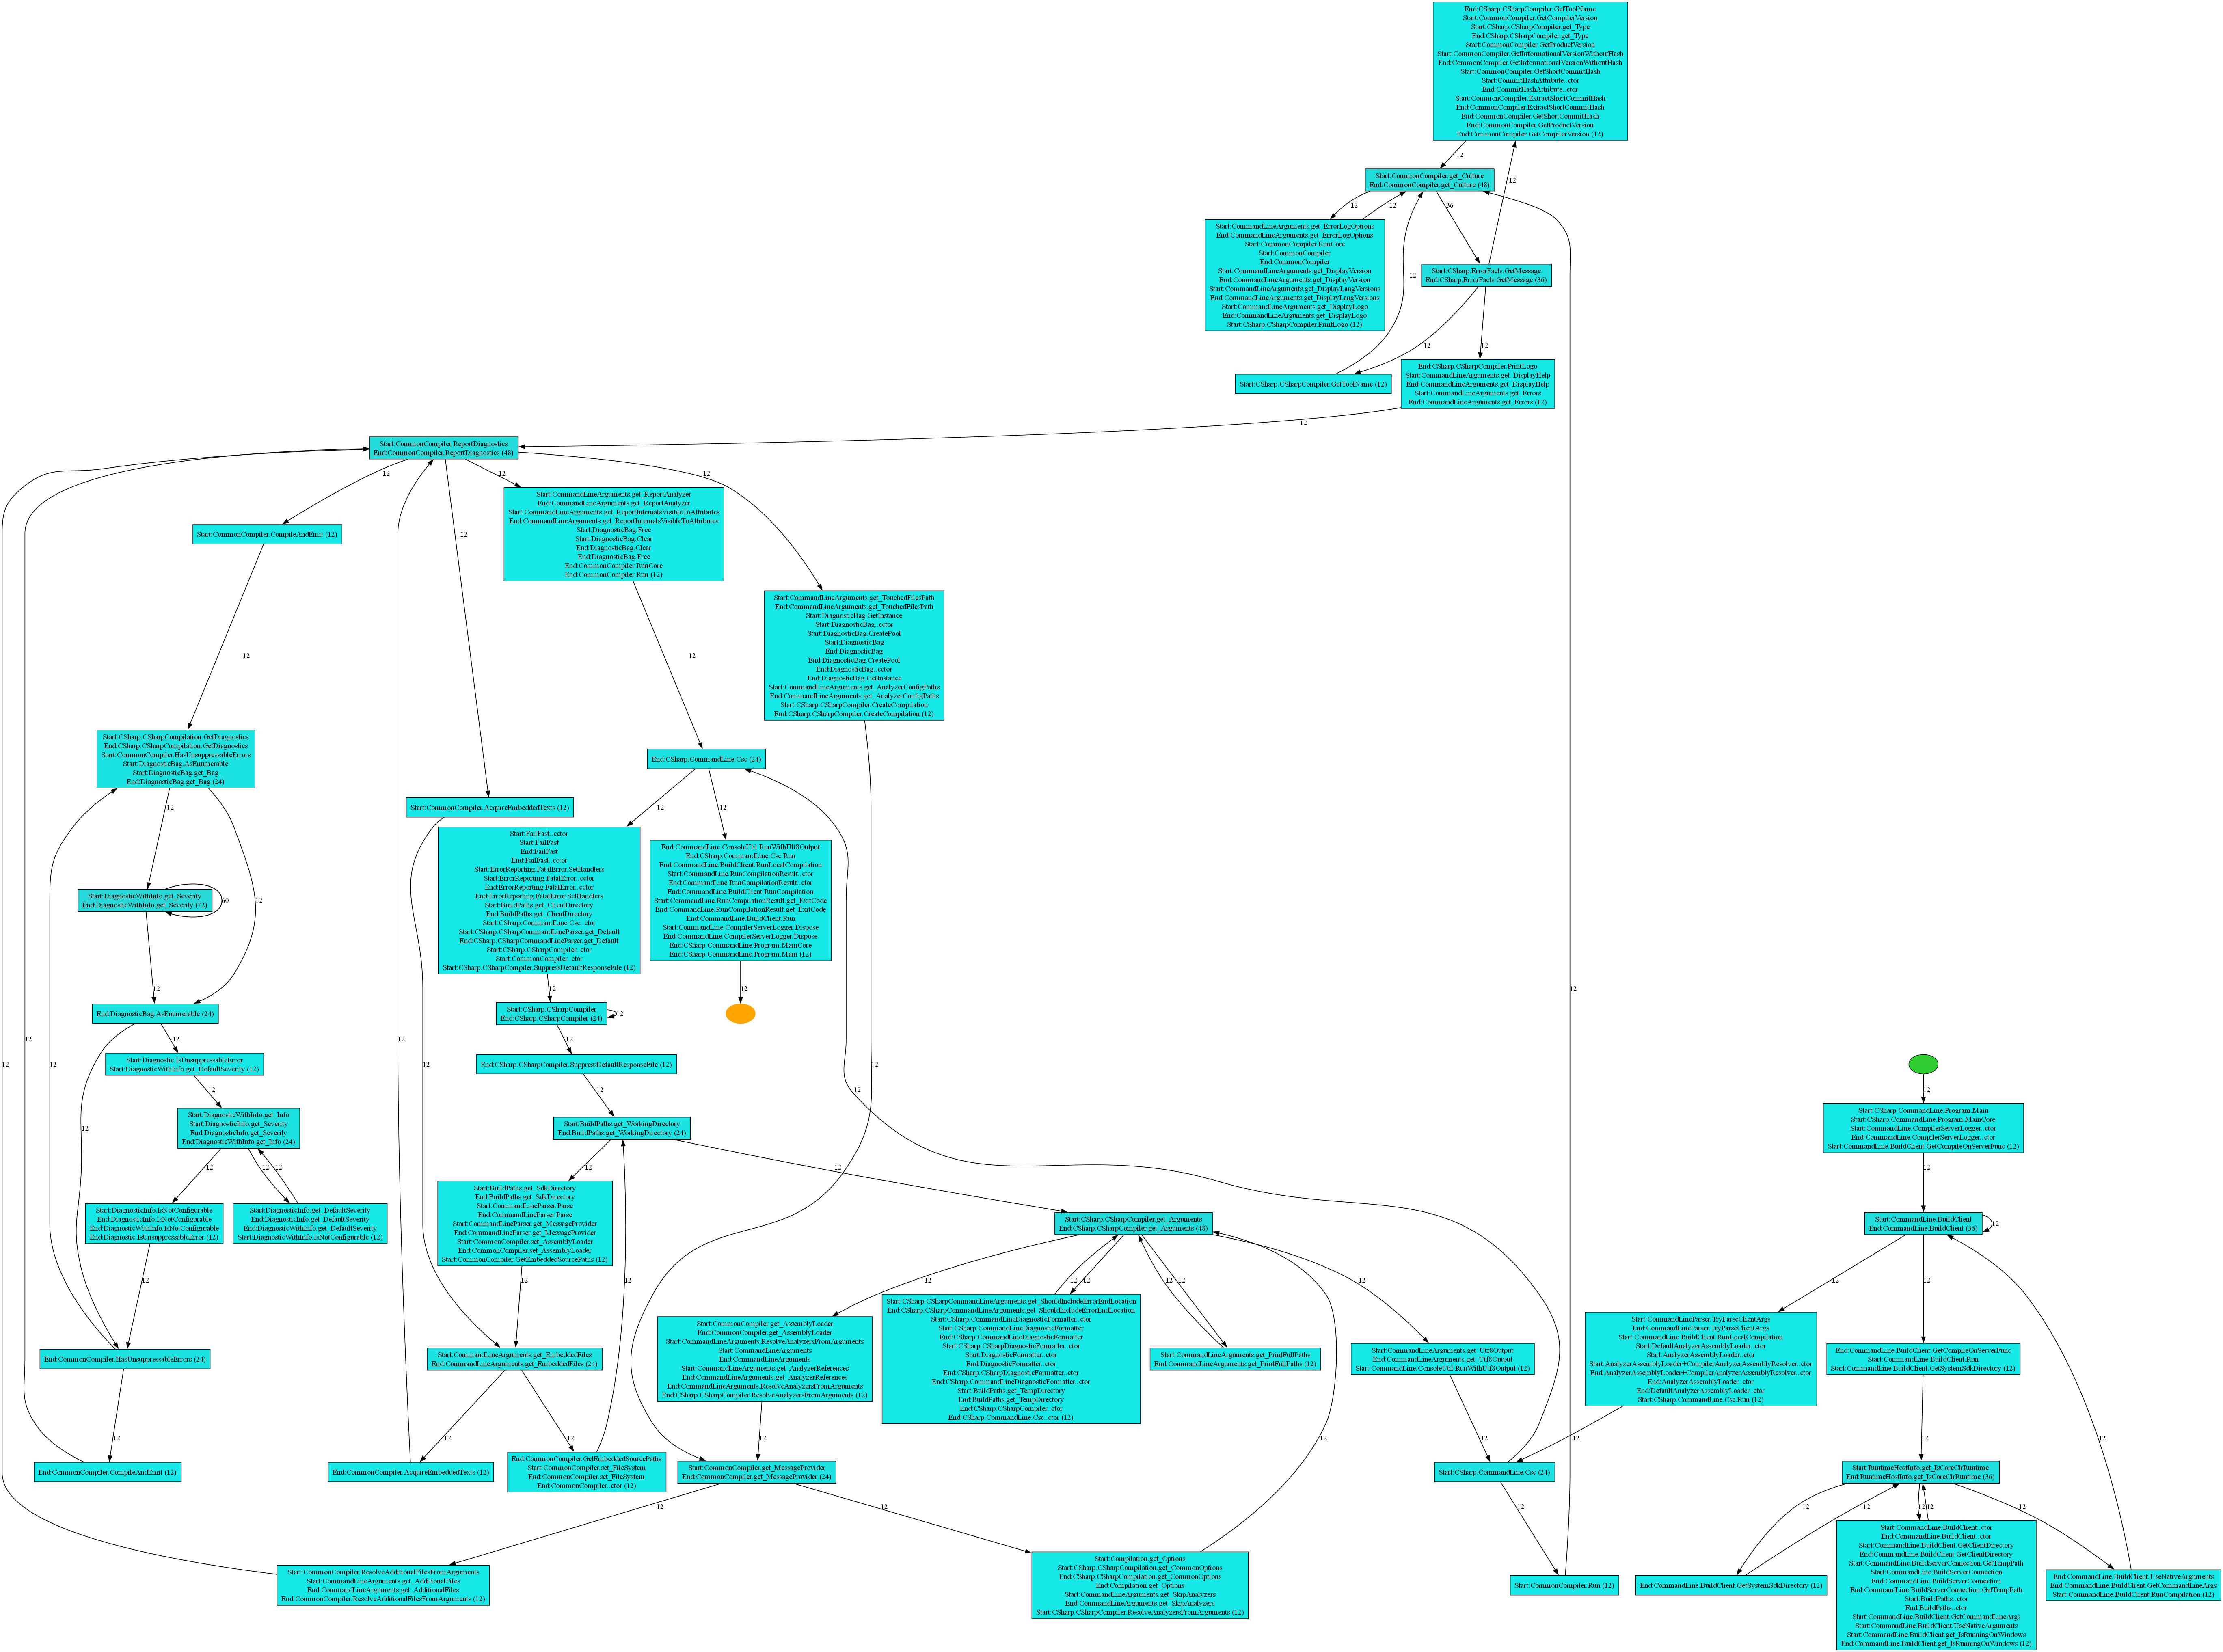

In [584]:
pm4py.view_heuristics_net(hn)